In [1]:
import pandas as pd
import re
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
from imblearn.over_sampling import SMOTE
import numpy as np
from transformers import TFBertForSequenceClassification
import tensorflow as tf
from tqdm.keras import TqdmCallback

In [ ]:
""""
# Paylaşılan sınıflandırma_train_data dosyasını zipten çıkardıktan sonra csv ye çevirmemiz gerekiyor. Eğer csv ye çevrilmişse bu adım atlanmalıdır. CSV çevrilmemiş, zipten çıkarılmışsa "news" klasörünün yolunu vermeniz gerekmektedir. Train için CSV dosyasının adı siniflandirma.csv olarak belirlenmiştir.


# news klasörünün yolu
news_directory = "news"

# Veri için bir liste oluştur
data = []

# News klasöründeki alt klasörleri ve dosyaları gezelim.
for category in os.listdir(news_directory):
    category_path = os.path.join(news_directory, category)
    if os.path.isdir(category_path):  # Klasör olup olmadığını kontrol et
        for file_name in os.listdir(category_path):
            file_path = os.path.join(category_path, file_name)
            if file_name.endswith(".txt"):  # Sadece .txt dosyalarını oku
                try:
                    with open(file_path, "r", encoding="utf-8") as file:
                        text = file.read().strip()  # Metni oku ve gereksiz boşlukları kaldır
                        data.append({"metin": text, "kategori": category})
                except Exception as e:
                    print(f"Dosya okunurken hata oluştu: {file_path}, Hata: {e}")

# Veriyi pandas DataFrame'e dönüştür
df = pd.DataFrame(data)

# CSV dosyasını kaydet
output_csv_path = "siniflandirma.csv"
df.to_csv(output_csv_path, index=False, encoding="utf-8")

print(f"Veriler '{output_csv_path}' dosyasına kaydedildi!")
"""

In [3]:
# Veriyi yükleme
df = pd.read_csv("siniflandirma.csv")
df

,metin,kategori
0,İnşaat çöktü: 8 yaralı\nKONYA'DA tek katlı inş...,yasam
1,Müzelik zihniyet\nYALOVA Açık Hava Müzesi'nin ...,yasam
2,İlk izlenim için 30 saniye yetiyor\nSakarya Ün...,yasam
3,Deprem tatbikatı gerçeğini aratmadı\nErzurum S...,yasam
4,74 köy yolu kapandı!\nVAN ve Hakkari'de iki gü...,yasam
...,...,...
21086,Beşiktaş deplasmanda güldü: 28-31\nErkekler He...,spor
21087,Kıran kırana mücadele\n2012-2013 sezonunda 10....,spor
21088,En büyük kupa Galatasaray'ın\nGalatasaray Teke...,spor
21089,ARKAS'tan müthiş dönüş\nAroma Erkekler Voleybo...,spor


In [4]:
df["kategori"].value_counts()

,count
kategori,
spor,7097
genel,4418
guncel,2755
dunya,2557
magazin,1000
saglik,991
turkiye,906
ekonomi,585
planet,327


In [5]:
# Metin temizleme fonksiyonu
def temizle(text):
    text = re.sub(r"[!'\n]", " ", text)  # Özel karakterleri kaldır
    text = re.sub(r"\s+", " ", text)     # Fazla boşlukları kaldır
    return text.strip().lower()          # Trim ve küçük harfe çevir

df["metin"] = df["metin"].apply(temizle)

In [6]:
from sklearn.utils import resample
#Dengesizliği çözmek (Oversampling)
dfs = []
max_samples = df["kategori"].value_counts().max()  # En büyük sınıf sayısı
for kategori in df["kategori"].unique():
    subset = df[df["kategori"] == kategori]
    upsampled = resample(subset, replace=True, n_samples=max_samples, random_state=42)
    dfs.append(upsampled)
df_balanced = pd.concat(dfs)

In [7]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_balanced["metin"].tolist(),
    df_balanced["kategori"].astype('category').cat.codes.tolist(),
    test_size=0.2,
    random_state=42
)

In [8]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
# Tokenizer ve model seçimi
tokenizer = BertTokenizer.from_pretrained("dbmdz/bert-base-turkish-cased")
model = BertForSequenceClassification.from_pretrained("dbmdz/bert-base-turkish-cased", num_labels=len(df["kategori"].unique()))


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/251k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
# Tokenizasyon
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)

In [10]:
import torch
import re
# PyTorch Dataset oluşturma
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

train_dataset = NewsDataset(train_encodings, train_labels)
test_dataset = NewsDataset(test_encodings, test_labels)

In [12]:
# Eğitim ayarları
training_args = TrainingArguments(
    output_dir="results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="logs",
    logging_steps=10,
    load_best_model_at_end=True,
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
)
# Model eğitimi
trainer.train()
# Modeli değerlendirme
results = trainer.evaluate()
print("Değerlendirme Sonuçları:", results)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-12-cc09b68c2ddc>:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss
1,0.215000,0.198268
2,0.106200,0.136634
3,0.027000,0.113453


Değerlendirme Sonuçları: {'eval_loss': 0.11345259845256805, 'eval_runtime': 107.7432, 'eval_samples_per_second': 158.089, 'eval_steps_per_second': 4.947, 'epoch': 3.0}


In [ ]:
import os

# Kaydedilecek dizini belirtin
save_dir = "saved_model"

# Klasör yoksa oluştur
os.makedirs(save_dir, exist_ok=True)

# Modeli kaydet
trainer.save_model(save_dir)

# Tokenizer'ı kaydet
tokenizer.save_pretrained(save_dir)

print(f"Model ve tokenizer {save_dir} dizinine kaydedildi.")


              precision    recall  f1-score   support

       yasam       0.96      0.99      0.97      1392
   teknoloji       0.98      1.00      0.99      1475
     turkiye       0.94      0.82      0.88      1473
       dunya       0.93      0.95      0.94      1362
     ekonomi       1.00      1.00      1.00      1439
       genel       0.97      1.00      0.99      1419
      guncel       1.00      1.00      1.00      1466
kultur-sanat       0.99      1.00      0.99      1390
     magazin       0.96      0.98      0.97      1416
      planet       1.00      1.00      1.00      1411
      saglik       0.98      0.99      0.99      1397
        spor       1.00      1.00      1.00      1393

    accuracy                           0.98     17033
   macro avg       0.98      0.98      0.98     17033
weighted avg       0.98      0.98      0.98     17033



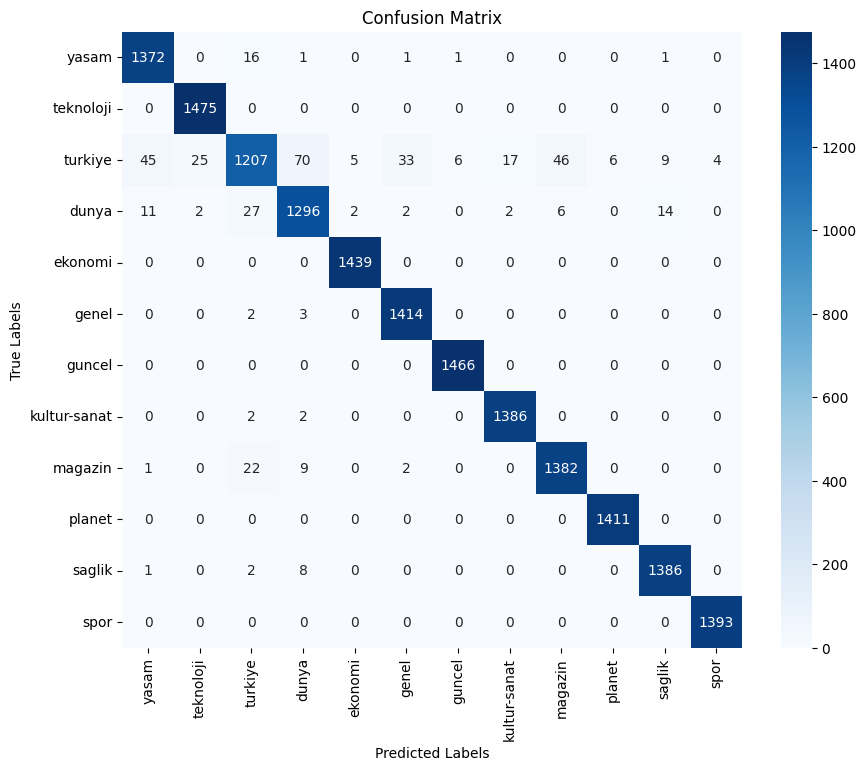

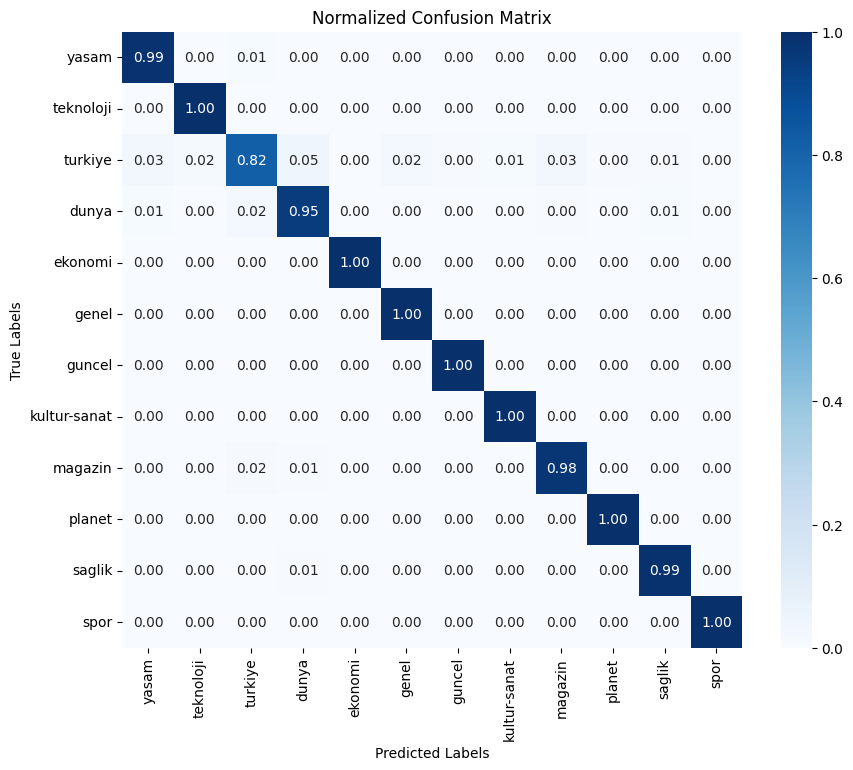

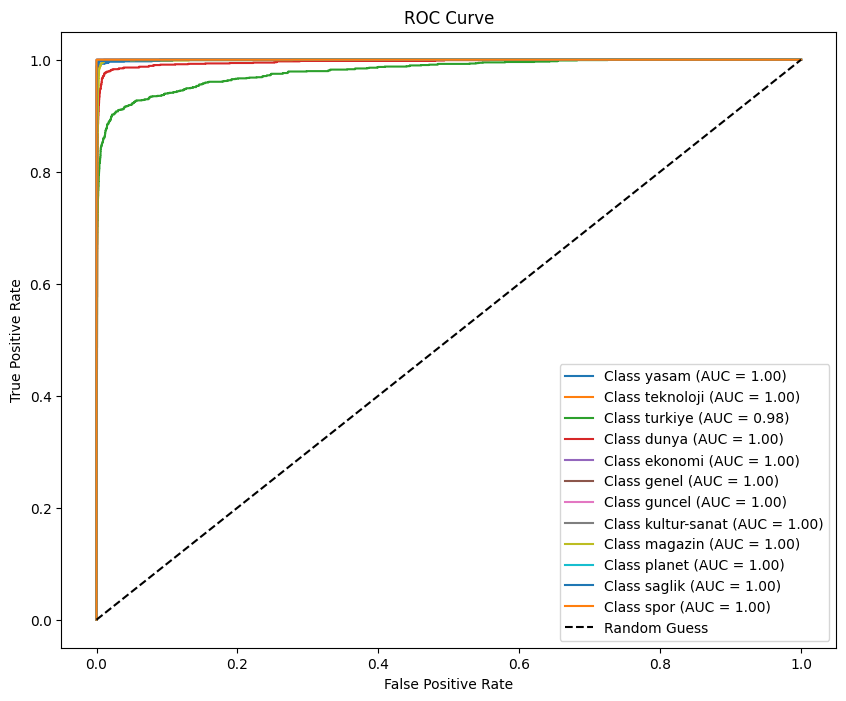

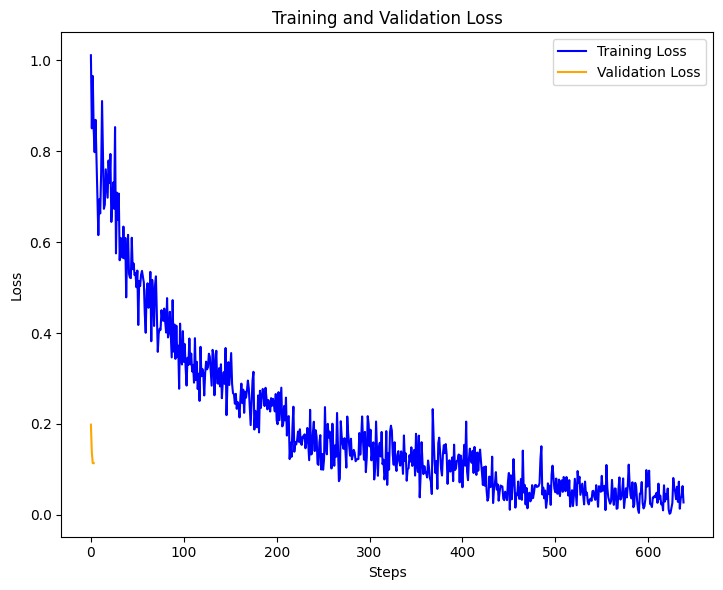

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Tahminler
predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = test_labels

# Classification report
report = classification_report(true_labels, predicted_labels, target_names=df["kategori"].unique())
print(report)


# Confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Çizim
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=df["kategori"].unique(), yticklabels=df["kategori"].unique())
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


# Normalized Confusion Matrix
cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

# Çizim
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=df["kategori"].unique(), yticklabels=df["kategori"].unique())
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Çok sınıflı ROC Eğrisi
fpr = {}
tpr = {}
roc_auc = {}
n_classes = len(df["kategori"].unique())
y_true = np.eye(n_classes)[true_labels]  # One-hot encode true labels

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], predictions.predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {df['kategori'].unique()[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

# Eğitim ve doğrulama loglarından accuracy/loss çekmek
train_loss = trainer.state.log_history
training_loss = [entry["loss"] for entry in train_loss if "loss" in entry]
eval_loss = [entry["eval_loss"] for entry in train_loss if "eval_loss" in entry]
steps = list(range(len(training_loss)))

# Accuracy ve Loss Grafiği
plt.figure(figsize=(14, 6))

# Loss Grafiği
plt.subplot(1, 2, 1)
plt.plot(steps, training_loss, label="Training Loss", color="blue")
plt.plot(steps[:len(eval_loss)], eval_loss, label="Validation Loss", color="orange")
plt.title("Training and Validation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()

# Accuracy Grafiği (Varsayılan log'dan)
if any("eval_accuracy" in entry for entry in train_loss):
    eval_acc = [entry["eval_accuracy"] for entry in train_loss if "eval_accuracy" in entry]
    plt.subplot(1, 2, 2)
    plt.plot(steps[:len(eval_acc)], eval_acc, label="Validation Accuracy", color="green")
    plt.title("Validation Accuracy")
    plt.xlabel("Steps")
    plt.ylabel("Accuracy")
    plt.legend()

plt.tight_layout()
plt.show()


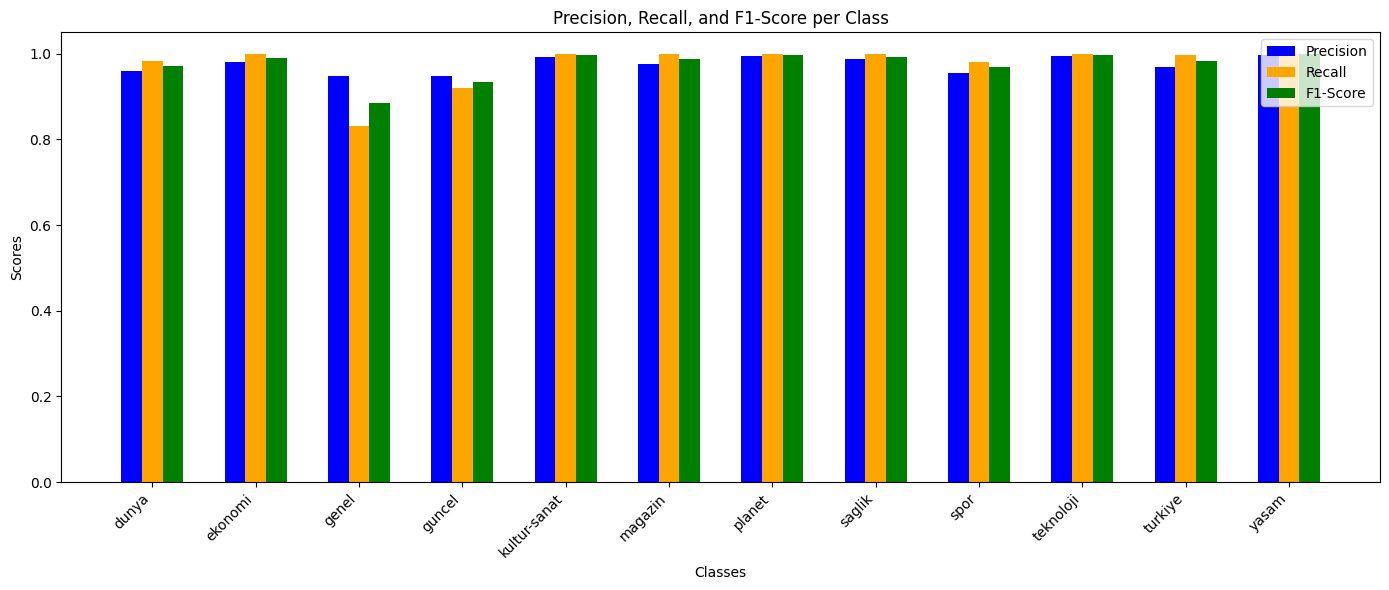

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Precision, Recall ve F1-Skorlarını hesaplama
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average=None)

# Çizim
classes = df["kategori"].unique()
plt.figure(figsize=(14, 6))
x = np.arange(len(classes))

# Precision, Recall ve F1 için çubuk grafik
plt.bar(x - 0.2, precision, 0.2, label="Precision", color="blue")
plt.bar(x, recall, 0.2, label="Recall", color="orange")
plt.bar(x + 0.2, f1, 0.2, label="F1-Score", color="green")

plt.xticks(x, classes, rotation=45, ha="right")
plt.title("Precision, Recall, and F1-Score per Class")
plt.xlabel("Classes")
plt.ylabel("Scores")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
"""
Test aşaması:

Eğitilen model, saved modele kaydedildi. 

Test aşamasında saved modeli kullanabilirsiniz.

Test veri setinin  "test_siniflandirma.csv" olması gerekmektedir. CSV dosyası, "metin|kategori" şeklinde tek sütun olduğu varsayılarak bazı işlemler yapılmıştır.

"metin" ve "kategori" iki farklı sütuna ayrılmış olup. Tahmin sonuçları için "tahmin_kategori" sütunu oluşturulup, tahminler bu sütuna kaydedilecektir.  Tahmin sonuçlu hali "test_siniflandirma_sonuc.csv" dosyasına kaydedilmiştir.

"""

In [ ]:
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import re

# Veriyi temizleme fonksiyonu
def temizle(text):
    text = re.sub(r"[!'\n]", " ", text)  # Özel karakterleri kaldır
    text = re.sub(r"\s+", " ", text)     # Fazla boşlukları kaldır
    return text.strip().lower()          # Trim ve küçük harfe çevir

# Kaydedilmiş modelin ve tokenizer'ın yüklenmesi
save_dir = "saved_model"
model = BertForSequenceClassification.from_pretrained(save_dir)
tokenizer = BertTokenizer.from_pretrained(save_dir)

# Sınıf isimlerini modelden çıkar ve güncel kategori isimlerine dönüştür
class_names = [
    "dunya", "ekonomi", "genel", "guncel", "kultur-sanat",
    "magazin", "planet", "saglik", "spor", "teknoloji",
    "turkiye", "yasam"
]
print(f"Modeldeki sınıflar: {class_names}")

# Test veri setinin yüklenmesi
test_file_path = "test_siniflandirma.csv"
test_df = pd.read_csv(test_file_path, sep="|", engine="python")

# Sütun adlarını kontrol et ve gerekirse ayarla
if list(test_df.columns) == ["metin", "kategori"]:
    print("Veri  doğru formatta.")
else:
    test_df.columns = ["metin", "kategori"]

# Metinleri temizleme
test_df["metin"] = test_df["metin"].apply(temizle)

# Tokenizasyon
test_encodings = tokenizer(test_df["metin"].tolist(), truncation=True, padding=True, max_length=512, return_tensors="pt")

# Modelin tahmin yapması
model.eval()
with torch.no_grad():
    outputs = model(**test_encodings)
    predictions = torch.argmax(outputs.logits, dim=1).numpy()

# Tahminleri kategori isimlerine çevir
test_df["tahmin_kategori"] = [class_names[pred] for pred in predictions]

# Sonuçları dosyaya kaydet
test_file_result = "test_siniflandirma_sonuc.csv"
test_df.to_csv(test_file_result, sep="|", index=False, header=True)
print(f"Tahminler {test_file_result} dosyasına başarıyla kaydedildi.")

# Tahmin sonuçlarını doğrulama
result = pd.read_csv(test_file_result, sep="|")
print(result.head(20))
